# MAT 388, HW4

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold

from numpy import mean
from numpy import std
import yfinance as yf
import tensorflow as tf
from scipy.io import loadmat
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import urllib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Activation, ConvLSTM2D, MaxPooling3D, Reshape
from keras.layers import  Conv2D, Dropout, Flatten, MaxPooling2D, LSTM, Embedding
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## Q1

For this question we are goint to use [CELEB_A](https://www.tensorflow.org/datasets/catalog/celeb_a) dataset through [tensorflow datasets](https://www.tensorflow.org/datasets).

1. Ingest the data, and select 10000 images from the dataset. Put the images under a variable called `X` and class labels (attributes) into `y`.
2. Build a neural network model for `X` against `Glasses` attribute in `y`.
3. Test the accuracy of your model using a 5-fold cross-validation. (I want a %95 confidence interval on the returned result using a t-test as I did in one of my lectures.)
4. Repeat Steps 2 and 3 for `Male` and `Bangs` attributes.
5. Compare your results for `Glasses`, `Male` and `Bangs`. Which one is better? Why? Explain.

In [ ]:
data, info = tfds.load('celeb_a', split=None, data_dir='/content/data', with_info=True, shuffle_files=True)

## Q2

For this question use the [Hyperspectral Image of Kennedy Space Center](https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Kennedy_Space_Center_.28KSC.29).

1. Ingest the image data directly from the web. (No local files!)
2. Ingest the ground truth data directly from the web. (No local files!)
4. Build a convolutional neural network (preferably using [this](https://keras.io/api/layers/convolution_layers/) and/or [this](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/)) model.
5. Test the accuracy of the model using a 5-fold cross-validation. (I want a %95 confidence interval on the returned result using a t-test as I did in one of my lectures.)

In [4]:
ksc_url = "http://www.ehu.es/ccwintco/uploads/2/26/KSC.mat"
urllib.request.urlretrieve(ksc_url, "ksc_data.mat")
ksc_gt_url = "http://www.ehu.es/ccwintco/uploads/a/a6/KSC_gt.mat"
urllib.request.urlretrieve(ksc_gt_url, "ksc_gt.mat")

('ksc_gt.mat', <http.client.HTTPMessage at 0x7f248670b3a0>)

In [5]:
ksc = loadmat('./ksc_data.mat')['KSC']
ksc_gt = loadmat('./ksc_gt.mat')['KSC_gt']
print(ksc.shape)
print(ksc_gt.shape)


(512, 614, 176)
(512, 614)


In [6]:
X = ksc.reshape(512*614, 4, 4, 11)

labeler = LabelBinarizer()
y = labeler.fit_transform(ksc_gt.reshape(512*614))
y.shape

(314368, 14)

I found kfold algoirthm on github(https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []
fold_no = 0

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, ksc_gt.reshape(512*614)):

  # Define the model architecture
    model = Sequential()
    model.add(ConvLSTM2D(32, kernel_size=(2, 2),padding='valid', return_sequences=True, input_shape=(512*614,4, 4, 11)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(14))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])
    print(model.summary())

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X[train], y[train], batch_size = 4, epochs = 10, validation_data = (X[test], y[test]))

    # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

## Q3

For this question we are going to use the time series of [Wheat Futures](https://finance.yahoo.com/quote/ZW=F/) from Yahoo Finance.

1. Ingest the data using [yfinance](https://pypi.org/project/yfinance/) Start from Jan 1, 2010 until Dec 31, 2021.
2. Construct [a RNN and/or a LSTM](https://keras.io/api/layers/recurrent_layers/) model on the data.
3. Test your model on the wheat futures data from Jan 1, 2022 to today using a 5-fold cross-validation. Did your model work? Explain.

In [80]:
data = yf.download('ZW=F', start="2010-01-01", end="2022-01-01")[['Close']]
test_data = yf.download('ZW=F', start="2021-12-31", end="2022-12-19")[['Close']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [81]:
scaler = StandardScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

data['Close2'] = data['Close'].shift(-1)
data.dropna(inplace = True)
X_train = data['Close']
y_train = data['Close2']

test_data['Close2'] = test_data['Close'].shift(-1)
test_data.dropna(inplace = True)
X_test = test_data['Close']
y_test = test_data['Close2']

<ipython-input-81-c6cd15d636c1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Close2'] = test_data['Close'].shift(-1)
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [82]:
# Define the model architecture
model = Sequential()
model.add(LSTM(64, input_shape=(1,1), activation='relu'))
model.add(Dense(128))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
print(model.summary())



# Fit data to model
model.fit(X_train,y_train,epochs=10,batch_size=5,validation_data=(X_test,y_test),verbose=1)
# Generate generalization metrics
scores = model.evaluate(X_test, y_test, verbose=0)




Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 64)                16896     
                                                                 
 dense_59 (Dense)            (None, 128)               8320      
                                                                 
 dense_60 (Dense)            (None, 1)                 129       
                                                                 
Total params: 25,345
Trainable params: 25,345
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
604/604 [==============================] - 2s 2ms/step - loss: 0.0377 - val_loss: 33088.6953
Epoch 2/10
604/604 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 36002.0391
Epoch 3/10
604/604 [==============================] - 1s 2ms/step - loss: 0.0100 - val_loss: 6585.36

In [83]:
y_pred = model.predict(X_test)
res = pd.DataFrame({'X_test': np.array(X_test).reshape(X_test.shape[0]), 
                    'Y_test': np.array(y_test).reshape(y_test.shape[0]), 
                    'Y_pred': np.array(y_pred).reshape(y_pred.shape[0])})
res

8/8 [==============================] - 0s 2ms/step


,X_test,Y_test,Y_pred
0,770.75,758.00,693.712158
1,758.00,770.00,682.422974
2,770.00,760.75,693.047913
3,760.75,746.00,684.857544
4,746.00,758.50,671.801880
...,...,...,...
237,712.75,733.00,642.392395
238,733.00,728.75,660.299927
239,728.75,728.25,656.540649
240,728.25,757.25,656.098450


In [84]:
model.evaluate(X_test, y_test, batch_size = 32) 

8/8 [==============================] - 0s 1ms/step - loss: 9745.4766


9745.4765625

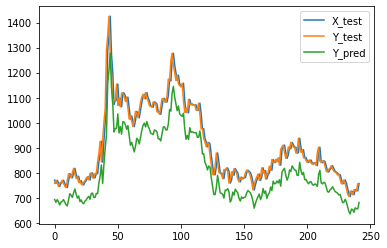

In [85]:
res.plot()

## Q4

For this question, we are going to use [Consumer Complaints Dataset](https://raw.githubusercontent.com/plotly/datasets/master/26k-consumer-complaints.csv).

1. Ingest the dataset. We are only going to use the columns `Issue` and `Timely Response?`.
2. Convert the values in the issue column to vectors using [Count Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from `scikit-learn`. Similarly, binarize the column `Timely Response` using [Label Binarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html).
3. Split your dataset into train and test.
3. Construct an an appropriate neural network model on the train set.
4. Test your model on the test set. Did your model work? Explain.

In [86]:
complaints = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/26k-consumer-complaints.csv')
data = complaints[['Issue', 'Timely response?']].dropna()
data.head()

,Issue,Timely response?
0,Communication tactics,Yes
1,Cont'd attempts collect debt not owed,Yes
2,"Application, originator, mortgage broker",Yes
3,Other,Yes
4,Cont'd attempts collect debt not owed,Yes


In [87]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['Issue']).toarray()


labeler= LabelBinarizer()

y = data['Timely response?'].values
y_binarized = labeler.fit_transform(y)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=0.25, random_state=42)


In [91]:
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[-1],), activation='relu'))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', 
              metrics = ['accuracy'],
              optimizer = 'adam')

model.fit(X_train, y_train,
          batch_size = 64,
          epochs = 10,
          validation_data = (X_test, y_test))

Epoch 1/10
330/330 [==============================] - 2s 5ms/step - loss: 0.1268 - accuracy: 0.9728 - val_loss: 0.1091 - val_accuracy: 0.9736
Epoch 2/10
330/330 [==============================] - 1s 2ms/step - loss: 0.1047 - accuracy: 0.9751 - val_loss: 0.1088 - val_accuracy: 0.9736
Epoch 3/10
330/330 [==============================] - 1s 2ms/step - loss: 0.1038 - accuracy: 0.9751 - val_loss: 0.1089 - val_accuracy: 0.9736
Epoch 4/10
330/330 [==============================] - 1s 2ms/step - loss: 0.1035 - accuracy: 0.9751 - val_loss: 0.1100 - val_accuracy: 0.9736
Epoch 5/10
330/330 [==============================] - 1s 2ms/step - loss: 0.1033 - accuracy: 0.9751 - val_loss: 0.1106 - val_accuracy: 0.9736
Epoch 6/10
330/330 [==============================] - 1s 2ms/step - loss: 0.1035 - accuracy: 0.9751 - val_loss: 0.1092 - val_accuracy: 0.9736
Epoch 7/10
330/330 [==============================] - 1s 2ms/step - loss: 0.1031 - accuracy: 0.9751 - val_loss: 0.1090 - val_accuracy: 0.9736
Epoch 

In [97]:
model.evaluate(X_test, y_test, batch_size = 32) 

220/220 [==============================] - 0s 998us/step - loss: 0.1084 - accuracy: 0.9736


[0.10838085412979126, 0.97357577085495]